## Prepare augments

In [2]:
import math
import os
import os.path as osp
import random

from typing import Union

import numpy as np
import torch

from bokeh.models import Plot, LinearColorMapper, ColumnDataSource, ColorBar
from bokeh.plotting import figure, output_notebook, show
from matplotlib import pyplot as plt
from torch import nn, Tensor
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

from sslh.datasets.esc10 import ESC10
from sslh.datasets.gsc import SpeechCommands
from sslh.datasets.gsc import TARGET_MAPPER as GSC_TARGET_MAPPER
from sslh.transforms.containers import RandomChoice
from sslh.transforms.spectrogram.cutoutspec import CutOutSpec
from sslh.transforms.spectrogram.flips import HorizontalFlip, VerticalFlip
from sslh.transforms.spectrogram.spec_aug import SpecAugmentation
from sslh.transforms.waveform.occlusion import Occlusion
from sslh.transforms.waveform.speed_perturbation import SpeedPerturbation

output_notebook()

Loading BokehJS ...

In [3]:
seed = 1234
random.seed(seed)
torch.random.manual_seed(seed)

## Plot functions

In [4]:
img_dpath = "nb_data"
os.makedirs(img_dpath, exist_ok=True)

In [5]:
def mpl_plot_wav(waveform: Tensor, name: str) -> None:
    plt.plot(waveform)
    plt.gca().set_axis_off()
    plt.savefig(osp.join(img_dpath, name))
    plt.gca().set_axis_on()
    plt.show()

def mpl_plot_spec(spec: Tensor, name: str) -> None:
    plt.imshow(spec, origin="lower")
    plt.gca().set_axis_off()
    plt.savefig(osp.join(img_dpath, name))
    plt.gca().set_axis_on()
    plt.show()

def bok_plot_wav(waveform: Tensor, name: str) -> Plot:
    raise NotImplementedError

In [6]:
import os
import os.path as osp
import subprocess as sp
from typing import Optional
from bokeh.io import export_svg, export_png
from bokeh.models import Plot
from selenium.webdriver import Firefox

def full_export(
    p: Plot,
    name_noext: str,
    dir: str = "nb_data",
    width: Optional[int] = None,
    height: Optional[int] = None,
    svg: bool = True,
    pdf: bool = True,
    png: bool = True,
) -> None:
    svg_fpath = osp.join(dir, name_noext) + ".svg"
    png_fpath = osp.join(dir, name_noext) + ".png"
    pdf_fpath = osp.join(dir, name_noext) + ".pdf"

    driver = Firefox()
    common_kwargs = dict(webdriver=driver, width=width, height=height)

    if svg or pdf:
        p.output_backend = "svg"  # type: ignore
        export_svg(p, filename=svg_fpath, **common_kwargs)

    if png:
        p.output_backend = "canvas"  # type: ignore
        export_png(p, filename=png_fpath, **common_kwargs)

    driver.close()

    if pdf:
        _ = sp.check_call(f"inkscape {svg_fpath} --export-pdf={pdf_fpath}".split())
    if pdf and not svg:
        os.remove(svg_fpath)

In [ ]:
def plot_spectrogram(
    spec: Union[Tensor, np.ndarray],
    title: Optional[str] = None,
    width: Optional[int] = None,  # x size
    height: Optional[int] = 400,  # y size
    add_colorbar: bool = False,
    specmin: Union[None, float] = None,
    specmax: Union[None, float] = None,
    verbose: int = 1,
) -> Plot:
    """
    :param spec: (channels, time steps, freqs)
    """
    if spec.ndim == 2:
        spec = spec[None, :, :]
    if isinstance(spec, Tensor):
        spec = spec.cpu().numpy()
    if specmin is None:
        specmin = spec.min().item()
    if specmax is None:
        specmax = spec.max().item()

    channel_size, time_size, freq_size = spec.shape

    if width is None and height is None:
        raise ValueError
    elif width is None and height is not None:
        width = round(time_size / freq_size * height)
    elif width is not None and height is None:
        height = round(freq_size / time_size * width)

    if verbose >= 1:
        print(f"Spec size: ({channel_size}, {time_size}, {freq_size})")
        print(f"Plot size: ({width}, {height})")

    color_mapper = LinearColorMapper(
        palette="Viridis256",
        low=specmin,
        high=specmax,
    )
    p = figure(
        width=width,
        height=height,
        title=title,
        x_range=[0, time_size],
        y_range=[0, freq_size],
        tooltips=[("x (time)", "$x"), ("y (freq)", "$y"), ("value", "@image")],
        x_axis_label="Time steps",
        y_axis_label="Frequencies",
    )

    p.toolbar.logo = None
    p.toolbar_location = None

    p.image(
        # image expects (nb_channels, height, width) ?
        image=list(spec.transpose(0, 2, 1)),  # type: ignore
        x=0,
        y=0,
        dw=time_size,
        dh=freq_size,
        color_mapper=color_mapper,
    )

    if add_colorbar:
        color_bar = ColorBar(color_mapper=color_mapper)
        p.add_layout(color_bar, "right")

    p.xaxis.visible = False
    p.yaxis.visible = False
    p.grid.visible = False

    show(p)
    return p

## Augmentations

- SpeedPerturbation only resample signal waveform of length L to length (L * rate) and pad/crop it to return a waveform of length L.
The rate is uniformly sampled from a pre-defined range "rates".

- CutOutSpec remove some value in a spectrogram by replacing value in a random rectangle area by -80.0 dB.
The width and height of the rectangle will be defined by scales (height_spec * height_scale, width_spec * width_scale),
where spectrogram has shape (height_spec, width_spec) and scales are uniformly generated in pre-defined ranges "width_scales" and "height_scales".

- Occlusion replace a interval of values in the waveform by 0.
The length of this interval is defined by the scale uniformly sampled from the range "scales".

In [22]:
def gen_note(freq_note: float, duration_s: float, sample_rate: int, amplitude: float = 1.0) -> Tensor:
    nb_samples = duration_s * sample_rate
    x = torch.arange(start=0, end=nb_samples)
    note = amplitude * torch.sin(freq_note * x * 2.0 * math.pi / sample_rate)
    return note

# 0.5 Hz, 10 s
wav_freq = 0.5
duration_s = 10
sr = 32000
waveform = gen_note(wav_freq, duration_s, sr)
print(f"{waveform.shape=}, {sr=}")

# root = "../../data/ESC10"
# dset = ESC10(root, download=False)
# sr = 44100
# duration_s = 5.0

root = "../../data/GSC"
dset = SpeechCommands(root, download=False)
sr = 16000
duration_s = 1.0

# idx = 163
# idx = 398
idx = random.randint(0, len(dset) - 1)
idx = 981
x, y = dset[idx]
mapper = {idx: name for name, idx in GSC_TARGET_MAPPER.items()}
y_name = mapper[y]
waveform = x.squeeze_(dim=0)
print(f"{waveform.shape=}, {sr=}, {idx=}, {y_name=}")

# Optional transform to spectrogram
n_mels = 64  # nb mels
n_fft = 2048  # window size
hop_length = 512

# n_time = 500  # nb spec time steps
# hop_length = math.floor(sr * duration_s) // n_time
print(f"{idx=}")
print(f"{duration_s=}")
print(f"{hop_length=}")

transform_to_spec = nn.Sequential(
    MelSpectrogram(sample_rate=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels),
    AmplitudeToDB(),
)
# Spec shape (mel, time) : (64, 501)
spec = transform_to_spec(waveform)
print(f"{spec.shape=}")

waveform.shape=torch.Size([320000]), sr=32000
waveform.shape=torch.Size([16000]), sr=16000, idx=981, y_name='backward'
idx=981
duration_s=1.0
hop_length=512
spec.shape=torch.Size([64, 32])


In [23]:
mode = "weak"
p = 1.0

if mode == "weak":
    speed_pertub = SpeedPerturbation(rates=(0.6, 0.7), p=p)
    cutout_spec = CutOutSpec(freq_scales=(0.1, 0.25), time_scales=(0.1, 0.25), fill_value=-80.0, p=p)
    occlusion = Occlusion(scales=(0.1, 0.25), p=p)
elif mode == "strong":
    speed_pertub = SpeedPerturbation(rates=(1.4, 1.4), p=p)
    cutout_spec = CutOutSpec(freq_scales=(0.4, 0.7), time_scales=(0.7, 0.8), fill_value=-80.0, p=p)
    occlusion = Occlusion(scales=(0.6, 0.6), p=p)
else:
    raise ValueError

spec_occ = transform_to_spec(occlusion(waveform))
spec_cut = cutout_spec(spec)
spec_per = transform_to_spec(speed_pertub(waveform))

plot_kwargs = dict(width=300, height=300, add_colorbar=False, verbose=0)
export_kwargs = dict(pdf=False, svg=False, png=True, width=1000, height=1000)

p_src = plot_spectrogram(spec.transpose(0, 1), **plot_kwargs)  #, f"Spectrogramme de \"{y_name}\""
p_occ = plot_spectrogram(spec_occ.transpose(0, 1), **plot_kwargs)  #, f"Occlusion"
p_cut = plot_spectrogram(spec_cut.transpose(0, 1), **plot_kwargs)  #, f"CutOut"
p_per = plot_spectrogram(spec_per.transpose(0, 1), **plot_kwargs)  #, f"Speed Perturbation"

full_export(p_src, f"spec{idx}", **export_kwargs)
full_export(p_occ, f"spec{idx}_{mode}_occlusion", **export_kwargs)
full_export(p_cut, f"spec{idx}_{mode}_cutout", **export_kwargs)
full_export(p_per, f"spec{idx}_{mode}_speed_perturbation", **export_kwargs)


## SpeedPerturbation example:

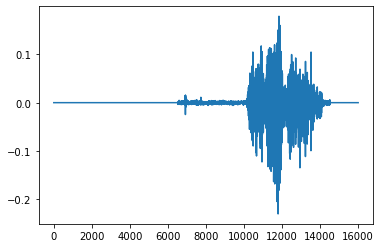

In [62]:
plt.plot(stretch(waveform))
plt.gca().set_axis_off()
plt.savefig(osp.join(img_dpath, 'example_waveform_time_stretch_pad_crop.png'))
plt.gca().set_axis_on()
plt.show()

## CutOutSpec example:

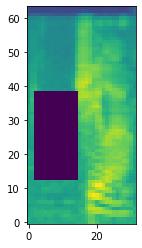

In [63]:
plt.imshow(cutout_spec(spec), origin="lower")
plt.gca().set_axis_off()
plt.savefig(osp.join(img_dpath, 'example_spectro_cutoutspec.png'))
plt.gca().set_axis_on()
plt.show()

## Occlusion example:

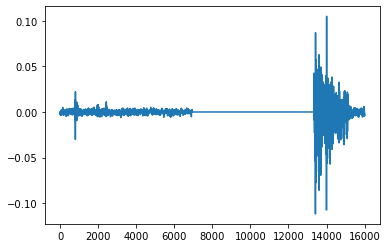

In [64]:
plt.plot(occlusion(waveform))
plt.savefig(osp.join(img_dpath, 'example_waveform_occlusion.png'))
plt.gca().set_axis_on()
plt.show()

## Augments composed example:

In [65]:
p = 0.5
augm = RandomChoice(
    nn.Sequential(
        SpeedPerturbation(rates=(0.9, 1.1), p=p),
        transform_to_spec,
    ),
    nn.Sequential(
        transform_to_spec,
        CutOutSpec(freq_scales=(0.1, 0.5), time_scales=(0.1, 0.5), fill_value=-80.0, p=p),
    ),
    nn.Sequential(
        Occlusion(scales=(0.1, 0.3), fill_value=0.0, p=p),
        transform_to_spec,
    ),
)
# print(augm)

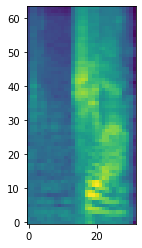

In [66]:
plt.imshow(augm(waveform), origin="lower")
plt.show()

## SpeedPerturbation on spec ?

In [67]:
stretch = SpeedPerturbation(rates=(0.5, 0.5), p=p)
waveform_stretch = stretch(waveform)
spec_stretch_1 = transform_to_spec(waveform_stretch)

stretch = SpeedPerturbation(rates=(0.5, 0.5), p=p, fill_value=-100.0)
spec_stretch_2 = stretch(spec)

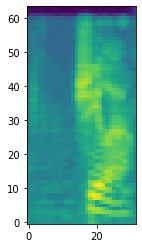

In [68]:
plt.imshow(spec_stretch_1, origin="lower")
plt.show()

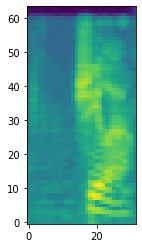

In [69]:
plt.imshow(spec_stretch_2, origin="lower")
plt.show()

## Occlusion on spec ?

In [70]:
occlusion = Occlusion(scales=(0.4, 0.4))
waveform_occlusion = occlusion(waveform)
spec_occlusion_1 = transform_to_spec(waveform_occlusion)

occlusion = Occlusion(scales=(0.4, 0.4), fill_value=-100.0)
spec_occlusion_2 = occlusion(spec)

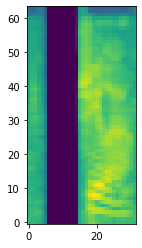

In [71]:
plt.imshow(spec_occlusion_1, origin="lower")
plt.show()

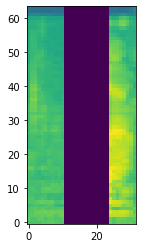

In [72]:
plt.imshow(spec_occlusion_2, origin="lower")
plt.show()


## Occlusion or CutOut ?

In [73]:
cutout_spec = CutOutSpec(freq_scales=(1.0, 1.0), time_scales=(0.4, 0.4), fill_value=-100.0)
spec_cutout_spec = cutout_spec(spec)

occlusion = Occlusion(scales=(0.4, 0.4), fill_value=-100.0)
spec_occlusion = occlusion(spec)

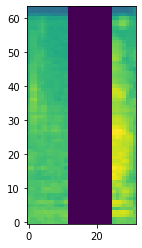

In [74]:
plt.imshow(spec_cutout_spec, origin="lower")
plt.show()

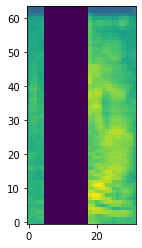

In [75]:
plt.imshow(spec_occlusion, origin="lower")
plt.show()

## Pitch Shift

In [76]:
from librosa.effects import pitch_shift

# print(spec.shape)
waveform_np = waveform.cpu().numpy()
waveform_ps = pitch_shift(waveform_np, sr, n_steps=4.0)
waveform_ps = torch.from_numpy(waveform_ps)

spec_ps = transform_to_spec(waveform_ps)

/tmp/ipykernel_278483/3607483412.py:5: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  waveform_ps = pitch_shift(waveform_np, sr, n_steps=4.0)


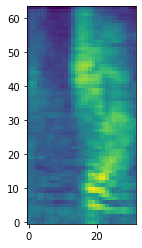

In [77]:
plt.imshow(spec_ps, origin="lower")
plt.show()

In [78]:
# from mlu.transforms.waveform.pitch_shift import PitchShift
# ps2 = PitchShift(sr, n_steps=4.0)
# waveform_ps2 = ps2(waveform)
# spec_ps2 = transform_to_spec(waveform_ps2)

In [79]:
# plt.imshow(spec_ps2, origin="lower")
# plt.show()


## CutOutSpec with other types of fill

In [80]:
cutout_spec = CutOutSpec(
	freq_scales=(0.5, 0.5),
	time_scales=(0.5, 0.5),
	fill_value=(-100, -80),
	fill_mode='random',
)

spec_cr = cutout_spec(spec)

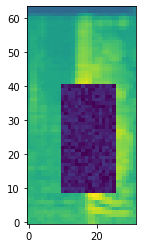

In [81]:
plt.imshow(spec_cr, origin="lower")
plt.show()


In [82]:
from sslh.transforms.other.fade import Fade
cutout_spec = CutOutSpec(
	freq_scales=(0.5, 0.5),
	time_scales=(0.5, 0.5),
	fill_mode=Fade(factor=0.5),
)

spec_cf = cutout_spec(spec)

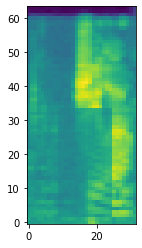

In [83]:
plt.imshow(spec_cf, origin="lower")
plt.show()

In [84]:
from sslh.transforms.other.noise import SubtractiveNoise
cutout_spec = CutOutSpec(
	freq_scales=(0.75, 0.75),
	time_scales=(0.75, 0.75),
	fill_mode=SubtractiveNoise(snr_db=15.0),
)

spec_cn = cutout_spec(spec)

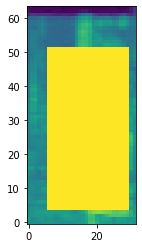

In [85]:
plt.imshow(spec_cn, origin="lower")
plt.show()

TimeStretch waveform or spec comparison

In [86]:
stretch = SpeedPerturbation(rates=(0.5, 0.5), p=p, align='left')
waveform_stretch = stretch(waveform)
spec_stretch_1 = transform_to_spec(waveform_stretch)

stretch = SpeedPerturbation(rates=(0.5, 0.5), p=p, fill_value=-100.0, align='left')
spec_stretch_2 = stretch(spec)

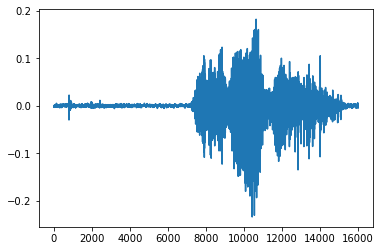

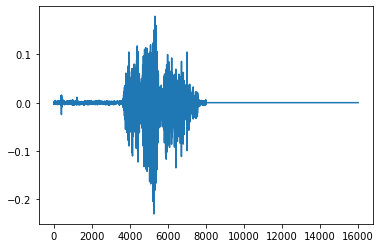

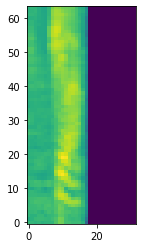

In [87]:
plt.plot(waveform)
plt.show()
plt.plot(waveform_stretch)
plt.show()
plt.imshow(spec_stretch_1, origin="lower")
plt.show()

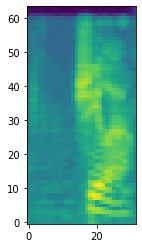

In [88]:
plt.imshow(spec_stretch_2, origin="lower")
plt.show()

In [89]:
diff = (spec_stretch_1 - spec_stretch_2).abs() + spec_stretch_1.min()


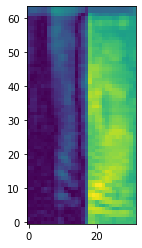

In [90]:
plt.imshow(diff, origin="lower")
plt.show()

SpeedPerturbation linear interpolation

In [91]:
from sslh.transforms.waveform.resample import Resample

# 0.5 Hz, 10 s
waveform2 = gen_note(20, 1, sr)

stretch_nearest = Resample(rates=(0.5, 0.5), interpolation='nearest')
stretch_linear = Resample(rates=(0.5, 0.5), interpolation='linear')

waveform2_stretch_nearest = stretch_nearest(waveform2)
waveform2_stretch_linear = stretch_linear(waveform2)

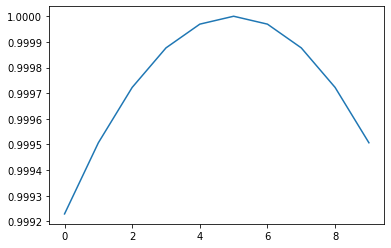

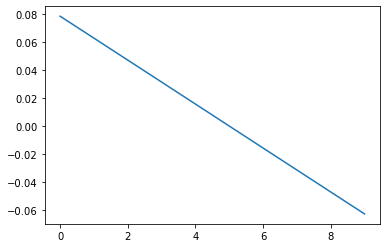

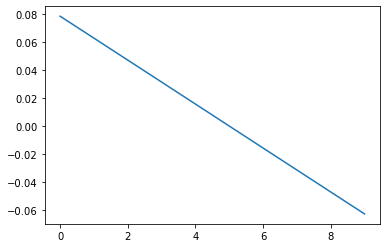

In [92]:
slices = slice(195, 205)

plt.plot(waveform2[slices])
plt.show()

plt.plot(waveform2_stretch_nearest[slices])
plt.show()

plt.plot(waveform2_stretch_linear[slices])
plt.show()

In [93]:
print(waveform2_stretch_nearest[slices].tolist())
print(waveform2_stretch_linear[slices].tolist())
print(waveform2_stretch_nearest.eq(waveform2_stretch_linear).all())

[0.07845903933048248, 0.06279022246599197, 0.04710638150572777, 0.03141068294644356, 0.015707235783338547, -8.742277657347586e-08, -0.015707410871982574, -0.031410858035087585, -0.047106556594371796, -0.0627906322479248]
[0.07849471271038055, 0.06281889230012894, 0.047127798199653625, 0.03142496943473816, 0.01571437530219555, -8.727733558089312e-08, -0.015714552253484726, -0.03142514452338219, -0.04712798446416855, -0.06281917542219162]
tensor(False)


CutOutSpec with different scales

In [94]:
cutoutspec_diff = CutOutSpec(freq_scales=(0.9, 1.0), time_scales=(0.0, 0.5))
spec_d = cutoutspec_diff(spec)

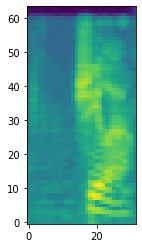

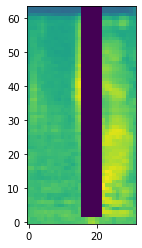

In [95]:
plt.imshow(spec, origin="lower")
plt.show()
plt.imshow(spec_d, origin="lower")
plt.show()

## Test flips

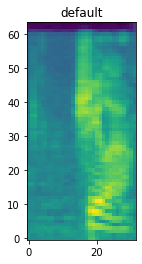

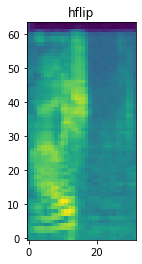

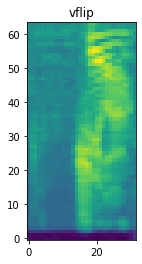

In [96]:
hflip = HorizontalFlip()
vflip = VerticalFlip()

plt.imshow(spec, origin="lower")
plt.title("default")
plt.show()
plt.imshow(hflip(spec), origin="lower")
plt.title("hflip")
plt.show()
plt.imshow(vflip(spec), origin="lower")
plt.title("vflip")
plt.show()

## Test SpecAugment

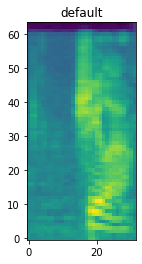

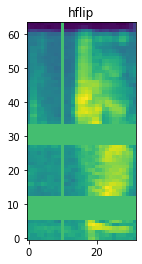

In [97]:
spec_aug = SpecAugmentation(16, 2, 2, 1, p=1.0, inplace=False)

plt.imshow(spec, origin="lower")
plt.title("default")
plt.show()
plt.imshow(spec_aug(spec.unsqueeze(dim=0)).squeeze(dim=0), origin="lower")
plt.title("hflip")
plt.show()